# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

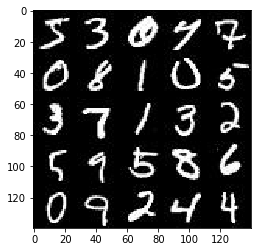

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

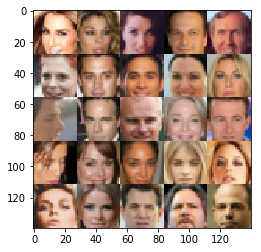

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    # warnings.warn('No GPU found. Please use a GPU to train your neural network.')
    print("I'm aware I don't have acess to a GPU...")
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
I'm aware I don't have acess to a GPU...


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, 
                                 shape=[None, image_width, image_height, image_channels],
                                 name='inputs_real')
    
    inputs_z = tf.placeholder(tf.float32,
                              shape=[None, z_dim],
                              name='inputs_z')
    
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2,
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.nn.dropout(x2, keep_prob=0.5)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.nn.dropout(x3, keep_prob=0.5)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    should_reuse = not is_train
    with tf.variable_scope('generator', reuse=should_reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=1,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                        padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, filters=64, kernel_size=5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64 now
        
        x5 = tf.layers.conv2d_transpose(x4, filters=32, kernel_size=5, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        # 56x56x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x1 or 28x28x3 now - depends on out_channel_dim
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, 
          batch_size, 
          z_dim, learning_rate, 
          beta1, 
          get_batches, 
          data_shape, 
          data_image_mode,
          log_every=20,
          display_every=80,
          show_images=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    total_steps = samples // batch_size * epoch_count
    
    print("Image width:", image_width)
    print("Image height:", image_height)
    print("Channels:", image_channels)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                # Scaling from -[0.5, 0.5] to [-1.0, 1.0] (tanh)
                batch_images = batch_images * 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if step % log_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch: {}/{}...".format(epoch_i + 1, epoch_count),
                          "Step: {}/{}...".format(step, total_steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if step % display_every == 0:
                    show_generator_output(sess, show_images, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Image width: 28
Image height: 28
Channels: 1
Epoch: 1/2... Step: 20/936... Discriminator Loss: 2.8064... Generator Loss: 0.1973
Epoch: 1/2... Step: 40/936... Discriminator Loss: 1.1494... Generator Loss: 1.1955
Epoch: 1/2... Step: 60/936... Discriminator Loss: 1.9770... Generator Loss: 0.3654
Epoch: 1/2... Step: 80/936... Discriminator Loss: 1.8875... Generator Loss: 0.4955


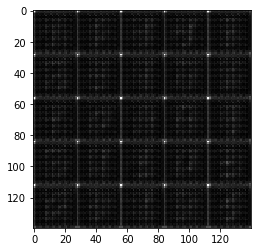

Epoch: 1/2... Step: 100/936... Discriminator Loss: 1.5278... Generator Loss: 1.3024
Epoch: 1/2... Step: 120/936... Discriminator Loss: 1.3137... Generator Loss: 1.3084
Epoch: 1/2... Step: 140/936... Discriminator Loss: 1.5949... Generator Loss: 0.8124
Epoch: 1/2... Step: 160/936... Discriminator Loss: 1.4194... Generator Loss: 0.6312


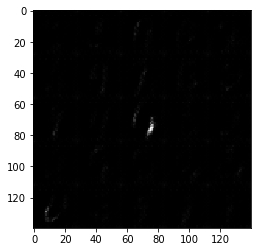

Epoch: 1/2... Step: 180/936... Discriminator Loss: 1.5527... Generator Loss: 0.6193
Epoch: 1/2... Step: 200/936... Discriminator Loss: 1.6471... Generator Loss: 1.0698
Epoch: 1/2... Step: 220/936... Discriminator Loss: 1.5697... Generator Loss: 0.9867
Epoch: 1/2... Step: 240/936... Discriminator Loss: 1.4176... Generator Loss: 0.7988


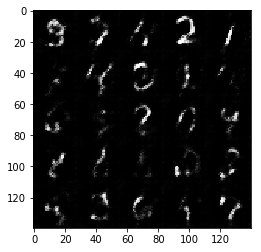

Epoch: 1/2... Step: 260/936... Discriminator Loss: 1.4316... Generator Loss: 1.0499
Epoch: 1/2... Step: 280/936... Discriminator Loss: 1.6018... Generator Loss: 0.4209
Epoch: 1/2... Step: 300/936... Discriminator Loss: 1.5161... Generator Loss: 0.8208
Epoch: 1/2... Step: 320/936... Discriminator Loss: 1.4358... Generator Loss: 0.8348


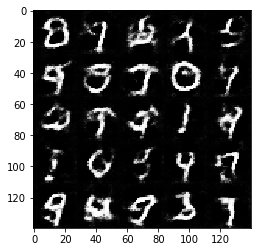

Epoch: 1/2... Step: 340/936... Discriminator Loss: 1.5308... Generator Loss: 1.1003
Epoch: 1/2... Step: 360/936... Discriminator Loss: 1.4980... Generator Loss: 1.0595
Epoch: 1/2... Step: 380/936... Discriminator Loss: 1.4284... Generator Loss: 0.8701
Epoch: 1/2... Step: 400/936... Discriminator Loss: 1.4385... Generator Loss: 0.9023


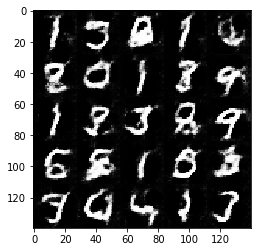

Epoch: 1/2... Step: 420/936... Discriminator Loss: 1.4905... Generator Loss: 0.4775
Epoch: 1/2... Step: 440/936... Discriminator Loss: 1.3205... Generator Loss: 0.9253
Epoch: 1/2... Step: 460/936... Discriminator Loss: 1.3493... Generator Loss: 0.7581
Epoch: 2/2... Step: 480/936... Discriminator Loss: 1.4199... Generator Loss: 0.5457


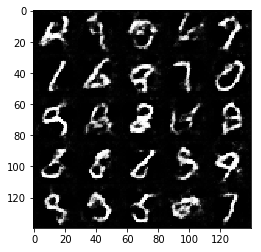

Epoch: 2/2... Step: 500/936... Discriminator Loss: 1.4234... Generator Loss: 0.7468
Epoch: 2/2... Step: 520/936... Discriminator Loss: 1.3827... Generator Loss: 0.6417
Epoch: 2/2... Step: 540/936... Discriminator Loss: 1.3777... Generator Loss: 0.7841
Epoch: 2/2... Step: 560/936... Discriminator Loss: 1.3616... Generator Loss: 0.7299


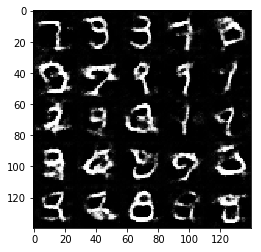

Epoch: 2/2... Step: 580/936... Discriminator Loss: 1.3699... Generator Loss: 1.1769
Epoch: 2/2... Step: 600/936... Discriminator Loss: 1.3854... Generator Loss: 0.6977
Epoch: 2/2... Step: 620/936... Discriminator Loss: 1.3011... Generator Loss: 0.8142
Epoch: 2/2... Step: 640/936... Discriminator Loss: 1.3882... Generator Loss: 0.8106


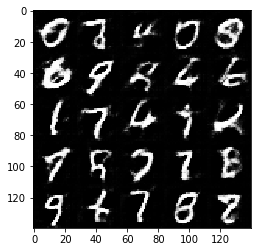

Epoch: 2/2... Step: 660/936... Discriminator Loss: 1.5059... Generator Loss: 0.6326
Epoch: 2/2... Step: 680/936... Discriminator Loss: 1.3719... Generator Loss: 0.8088
Epoch: 2/2... Step: 700/936... Discriminator Loss: 1.4026... Generator Loss: 0.4918
Epoch: 2/2... Step: 720/936... Discriminator Loss: 1.3677... Generator Loss: 0.7087


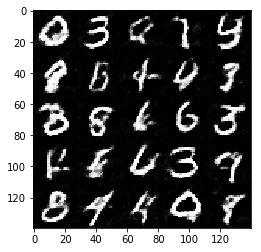

Epoch: 2/2... Step: 740/936... Discriminator Loss: 1.3370... Generator Loss: 0.8308
Epoch: 2/2... Step: 760/936... Discriminator Loss: 1.3543... Generator Loss: 0.6392
Epoch: 2/2... Step: 780/936... Discriminator Loss: 1.5012... Generator Loss: 0.6511
Epoch: 2/2... Step: 800/936... Discriminator Loss: 1.3517... Generator Loss: 0.9273


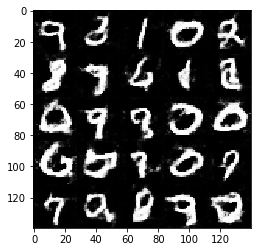

Epoch: 2/2... Step: 820/936... Discriminator Loss: 1.3877... Generator Loss: 0.8334
Epoch: 2/2... Step: 840/936... Discriminator Loss: 1.3496... Generator Loss: 0.9610
Epoch: 2/2... Step: 860/936... Discriminator Loss: 1.4241... Generator Loss: 0.8701
Epoch: 2/2... Step: 880/936... Discriminator Loss: 1.3396... Generator Loss: 1.0082


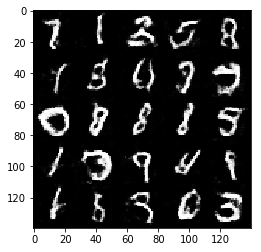

Epoch: 2/2... Step: 900/936... Discriminator Loss: 1.5838... Generator Loss: 1.3387
Epoch: 2/2... Step: 920/936... Discriminator Loss: 1.3711... Generator Loss: 0.7054


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Image width: 28
Image height: 28
Channels: 3
Epoch: 1/2... Step: 20/3164... Discriminator Loss: 2.2631... Generator Loss: 6.3194
Epoch: 1/2... Step: 40/3164... Discriminator Loss: 2.3633... Generator Loss: 0.6727
Epoch: 1/2... Step: 60/3164... Discriminator Loss: 2.1917... Generator Loss: 0.2954
Epoch: 1/2... Step: 80/3164... Discriminator Loss: 1.2580... Generator Loss: 0.9442


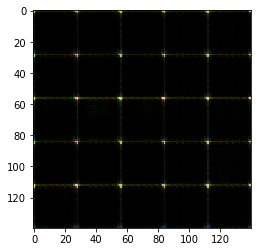

Epoch: 1/2... Step: 100/3164... Discriminator Loss: 1.9225... Generator Loss: 0.3631
Epoch: 1/2... Step: 120/3164... Discriminator Loss: 0.9828... Generator Loss: 0.9750
Epoch: 1/2... Step: 140/3164... Discriminator Loss: 1.2913... Generator Loss: 0.9466
Epoch: 1/2... Step: 160/3164... Discriminator Loss: 1.2396... Generator Loss: 1.5611


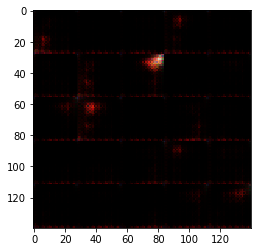

Epoch: 1/2... Step: 180/3164... Discriminator Loss: 1.8564... Generator Loss: 2.4840
Epoch: 1/2... Step: 200/3164... Discriminator Loss: 1.5968... Generator Loss: 0.7519
Epoch: 1/2... Step: 220/3164... Discriminator Loss: 1.4464... Generator Loss: 0.6071
Epoch: 1/2... Step: 240/3164... Discriminator Loss: 1.4779... Generator Loss: 1.2327


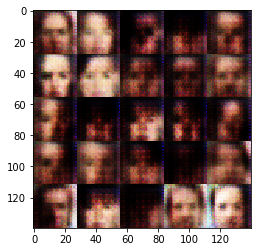

Epoch: 1/2... Step: 260/3164... Discriminator Loss: 1.5216... Generator Loss: 0.4650
Epoch: 1/2... Step: 280/3164... Discriminator Loss: 1.4680... Generator Loss: 0.8473
Epoch: 1/2... Step: 300/3164... Discriminator Loss: 1.4115... Generator Loss: 0.8719
Epoch: 1/2... Step: 320/3164... Discriminator Loss: 1.4439... Generator Loss: 0.9321


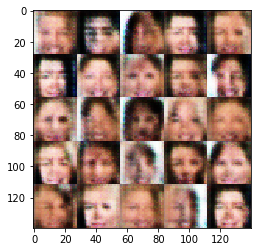

Epoch: 1/2... Step: 340/3164... Discriminator Loss: 1.7039... Generator Loss: 0.5370
Epoch: 1/2... Step: 360/3164... Discriminator Loss: 1.3972... Generator Loss: 1.0716
Epoch: 1/2... Step: 380/3164... Discriminator Loss: 1.4223... Generator Loss: 0.7870
Epoch: 1/2... Step: 400/3164... Discriminator Loss: 1.4571... Generator Loss: 1.0002


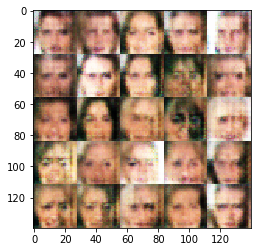

Epoch: 1/2... Step: 420/3164... Discriminator Loss: 1.4255... Generator Loss: 0.6370
Epoch: 1/2... Step: 440/3164... Discriminator Loss: 1.3598... Generator Loss: 0.8292
Epoch: 1/2... Step: 460/3164... Discriminator Loss: 1.6271... Generator Loss: 1.2506
Epoch: 1/2... Step: 480/3164... Discriminator Loss: 1.4925... Generator Loss: 0.8317


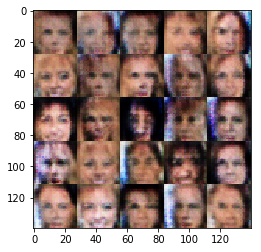

Epoch: 1/2... Step: 500/3164... Discriminator Loss: 1.3338... Generator Loss: 0.9246
Epoch: 1/2... Step: 520/3164... Discriminator Loss: 1.4235... Generator Loss: 0.8202
Epoch: 1/2... Step: 540/3164... Discriminator Loss: 1.5285... Generator Loss: 0.9468
Epoch: 1/2... Step: 560/3164... Discriminator Loss: 1.3030... Generator Loss: 0.7633


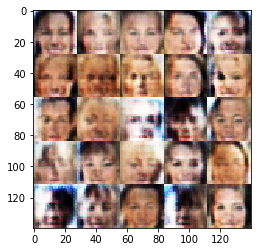

Epoch: 1/2... Step: 580/3164... Discriminator Loss: 1.4455... Generator Loss: 1.0805
Epoch: 1/2... Step: 600/3164... Discriminator Loss: 1.3071... Generator Loss: 0.7648
Epoch: 1/2... Step: 620/3164... Discriminator Loss: 1.3413... Generator Loss: 0.4872
Epoch: 1/2... Step: 640/3164... Discriminator Loss: 1.4396... Generator Loss: 1.0745


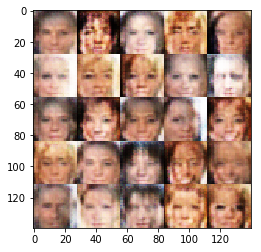

Epoch: 1/2... Step: 660/3164... Discriminator Loss: 1.4222... Generator Loss: 1.0865
Epoch: 1/2... Step: 680/3164... Discriminator Loss: 1.4282... Generator Loss: 0.8898
Epoch: 1/2... Step: 700/3164... Discriminator Loss: 1.3279... Generator Loss: 1.1347
Epoch: 1/2... Step: 720/3164... Discriminator Loss: 1.3924... Generator Loss: 0.9357


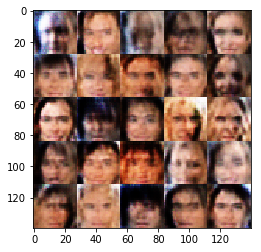

Epoch: 1/2... Step: 740/3164... Discriminator Loss: 1.3720... Generator Loss: 0.9176
Epoch: 1/2... Step: 760/3164... Discriminator Loss: 1.3174... Generator Loss: 0.7418
Epoch: 1/2... Step: 780/3164... Discriminator Loss: 1.3837... Generator Loss: 1.0669
Epoch: 1/2... Step: 800/3164... Discriminator Loss: 1.4518... Generator Loss: 0.4817


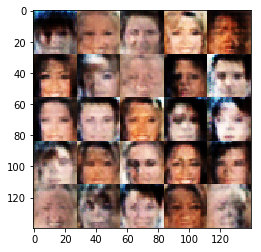

Epoch: 1/2... Step: 820/3164... Discriminator Loss: 1.5064... Generator Loss: 0.5447
Epoch: 1/2... Step: 840/3164... Discriminator Loss: 1.3124... Generator Loss: 0.6509
Epoch: 1/2... Step: 860/3164... Discriminator Loss: 1.4356... Generator Loss: 0.5215
Epoch: 1/2... Step: 880/3164... Discriminator Loss: 1.3844... Generator Loss: 0.6600


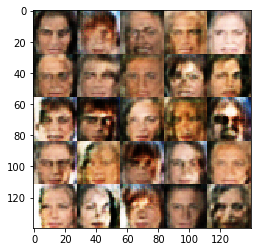

Epoch: 1/2... Step: 900/3164... Discriminator Loss: 1.5069... Generator Loss: 0.9262
Epoch: 1/2... Step: 920/3164... Discriminator Loss: 1.3467... Generator Loss: 0.7325
Epoch: 1/2... Step: 940/3164... Discriminator Loss: 1.3051... Generator Loss: 0.6454
Epoch: 1/2... Step: 960/3164... Discriminator Loss: 1.5967... Generator Loss: 0.5404


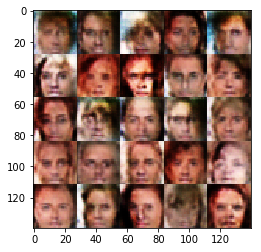

Epoch: 1/2... Step: 980/3164... Discriminator Loss: 1.4323... Generator Loss: 0.8359
Epoch: 1/2... Step: 1000/3164... Discriminator Loss: 1.5740... Generator Loss: 0.4941
Epoch: 1/2... Step: 1020/3164... Discriminator Loss: 1.3480... Generator Loss: 0.6689
Epoch: 1/2... Step: 1040/3164... Discriminator Loss: 1.3829... Generator Loss: 0.6996


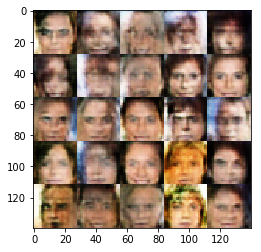

Epoch: 1/2... Step: 1060/3164... Discriminator Loss: 1.3192... Generator Loss: 0.7151
Epoch: 1/2... Step: 1080/3164... Discriminator Loss: 1.3823... Generator Loss: 0.5935
Epoch: 1/2... Step: 1100/3164... Discriminator Loss: 1.3831... Generator Loss: 0.7434
Epoch: 1/2... Step: 1120/3164... Discriminator Loss: 1.4613... Generator Loss: 0.7479


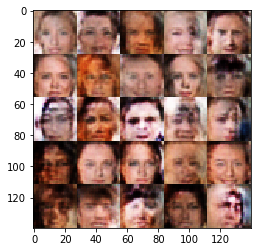

Epoch: 1/2... Step: 1140/3164... Discriminator Loss: 1.3396... Generator Loss: 0.8686
Epoch: 1/2... Step: 1160/3164... Discriminator Loss: 1.3183... Generator Loss: 0.7659
Epoch: 1/2... Step: 1180/3164... Discriminator Loss: 1.3946... Generator Loss: 0.8934
Epoch: 1/2... Step: 1200/3164... Discriminator Loss: 1.4157... Generator Loss: 0.8507


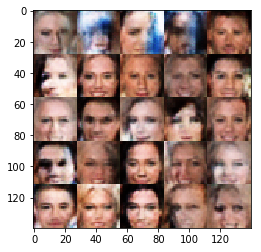

Epoch: 1/2... Step: 1220/3164... Discriminator Loss: 1.3723... Generator Loss: 0.7924
Epoch: 1/2... Step: 1240/3164... Discriminator Loss: 1.3365... Generator Loss: 0.5949
Epoch: 1/2... Step: 1260/3164... Discriminator Loss: 1.4359... Generator Loss: 0.9445
Epoch: 1/2... Step: 1280/3164... Discriminator Loss: 1.4429... Generator Loss: 0.5844


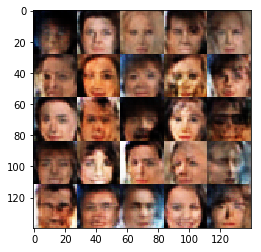

Epoch: 1/2... Step: 1300/3164... Discriminator Loss: 1.4240... Generator Loss: 0.9844
Epoch: 1/2... Step: 1320/3164... Discriminator Loss: 1.4676... Generator Loss: 0.7345
Epoch: 1/2... Step: 1340/3164... Discriminator Loss: 1.3619... Generator Loss: 0.8244
Epoch: 1/2... Step: 1360/3164... Discriminator Loss: 1.3908... Generator Loss: 0.6441


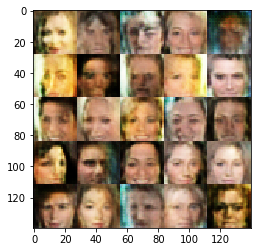

Epoch: 1/2... Step: 1380/3164... Discriminator Loss: 1.3710... Generator Loss: 0.6280
Epoch: 1/2... Step: 1400/3164... Discriminator Loss: 1.3349... Generator Loss: 0.8192
Epoch: 1/2... Step: 1420/3164... Discriminator Loss: 1.4033... Generator Loss: 0.7559
Epoch: 1/2... Step: 1440/3164... Discriminator Loss: 1.4146... Generator Loss: 0.7175


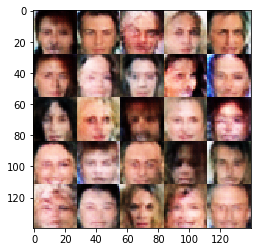

Epoch: 1/2... Step: 1460/3164... Discriminator Loss: 1.4051... Generator Loss: 0.7456
Epoch: 1/2... Step: 1480/3164... Discriminator Loss: 1.4249... Generator Loss: 0.9745
Epoch: 1/2... Step: 1500/3164... Discriminator Loss: 1.2812... Generator Loss: 0.7775
Epoch: 1/2... Step: 1520/3164... Discriminator Loss: 1.3734... Generator Loss: 0.8262


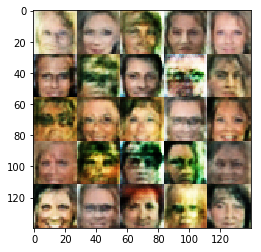

Epoch: 1/2... Step: 1540/3164... Discriminator Loss: 1.3104... Generator Loss: 0.8076
Epoch: 1/2... Step: 1560/3164... Discriminator Loss: 1.3651... Generator Loss: 1.0062
Epoch: 1/2... Step: 1580/3164... Discriminator Loss: 1.4440... Generator Loss: 0.8449
Epoch: 2/2... Step: 1600/3164... Discriminator Loss: 1.4263... Generator Loss: 0.7913


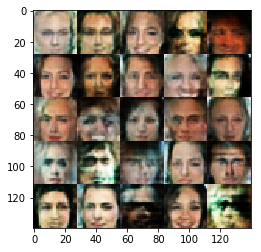

Epoch: 2/2... Step: 1620/3164... Discriminator Loss: 1.3884... Generator Loss: 0.7402
Epoch: 2/2... Step: 1640/3164... Discriminator Loss: 1.3825... Generator Loss: 0.6214
Epoch: 2/2... Step: 1660/3164... Discriminator Loss: 1.4745... Generator Loss: 0.5172
Epoch: 2/2... Step: 1680/3164... Discriminator Loss: 1.4159... Generator Loss: 0.7359


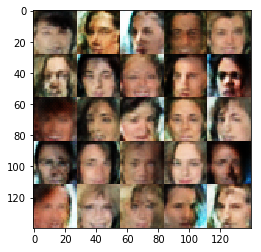

Epoch: 2/2... Step: 1700/3164... Discriminator Loss: 1.3406... Generator Loss: 0.7369
Epoch: 2/2... Step: 1720/3164... Discriminator Loss: 1.3731... Generator Loss: 0.9275
Epoch: 2/2... Step: 1740/3164... Discriminator Loss: 1.3180... Generator Loss: 0.8226
Epoch: 2/2... Step: 1760/3164... Discriminator Loss: 1.3376... Generator Loss: 0.8533


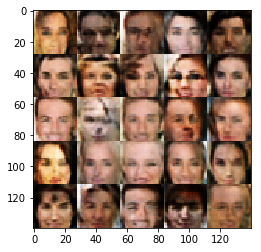

Epoch: 2/2... Step: 1780/3164... Discriminator Loss: 1.3916... Generator Loss: 0.6420
Epoch: 2/2... Step: 1800/3164... Discriminator Loss: 1.4296... Generator Loss: 0.5778
Epoch: 2/2... Step: 1820/3164... Discriminator Loss: 1.4560... Generator Loss: 0.7102
Epoch: 2/2... Step: 1840/3164... Discriminator Loss: 1.4078... Generator Loss: 0.6310


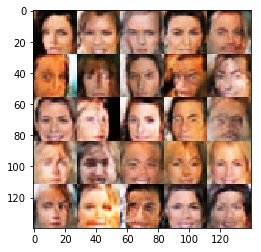

Epoch: 2/2... Step: 1860/3164... Discriminator Loss: 1.3891... Generator Loss: 0.7024
Epoch: 2/2... Step: 1880/3164... Discriminator Loss: 1.4140... Generator Loss: 0.6433
Epoch: 2/2... Step: 1900/3164... Discriminator Loss: 1.3833... Generator Loss: 0.8146
Epoch: 2/2... Step: 1920/3164... Discriminator Loss: 1.3709... Generator Loss: 0.6042


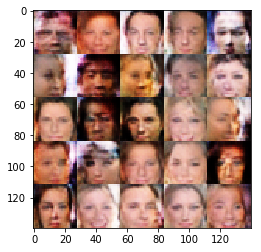

Epoch: 2/2... Step: 1940/3164... Discriminator Loss: 1.3562... Generator Loss: 0.7016
Epoch: 2/2... Step: 1960/3164... Discriminator Loss: 1.3334... Generator Loss: 0.6780
Epoch: 2/2... Step: 1980/3164... Discriminator Loss: 1.3414... Generator Loss: 0.8328
Epoch: 2/2... Step: 2000/3164... Discriminator Loss: 1.3480... Generator Loss: 0.7153


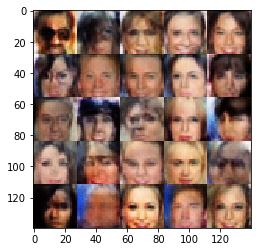

Epoch: 2/2... Step: 2020/3164... Discriminator Loss: 1.3543... Generator Loss: 0.9197
Epoch: 2/2... Step: 2040/3164... Discriminator Loss: 1.3453... Generator Loss: 0.6405
Epoch: 2/2... Step: 2060/3164... Discriminator Loss: 1.3818... Generator Loss: 0.6077
Epoch: 2/2... Step: 2080/3164... Discriminator Loss: 1.3765... Generator Loss: 0.6763


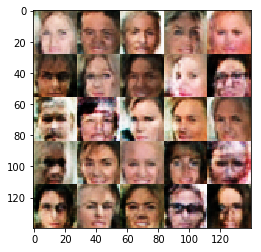

Epoch: 2/2... Step: 2100/3164... Discriminator Loss: 1.4312... Generator Loss: 0.8456
Epoch: 2/2... Step: 2120/3164... Discriminator Loss: 1.3444... Generator Loss: 0.7215
Epoch: 2/2... Step: 2140/3164... Discriminator Loss: 1.4352... Generator Loss: 0.5714
Epoch: 2/2... Step: 2160/3164... Discriminator Loss: 1.3646... Generator Loss: 0.6063


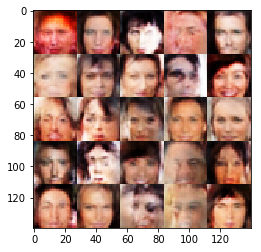

Epoch: 2/2... Step: 2180/3164... Discriminator Loss: 1.3459... Generator Loss: 0.7935
Epoch: 2/2... Step: 2200/3164... Discriminator Loss: 1.3574... Generator Loss: 0.8265
Epoch: 2/2... Step: 2220/3164... Discriminator Loss: 1.4054... Generator Loss: 0.6641
Epoch: 2/2... Step: 2240/3164... Discriminator Loss: 1.3726... Generator Loss: 0.6521


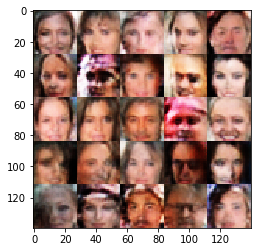

Epoch: 2/2... Step: 2260/3164... Discriminator Loss: 1.3998... Generator Loss: 0.7454
Epoch: 2/2... Step: 2280/3164... Discriminator Loss: 1.4186... Generator Loss: 0.5978
Epoch: 2/2... Step: 2300/3164... Discriminator Loss: 1.3617... Generator Loss: 0.7816
Epoch: 2/2... Step: 2320/3164... Discriminator Loss: 1.3890... Generator Loss: 0.7980


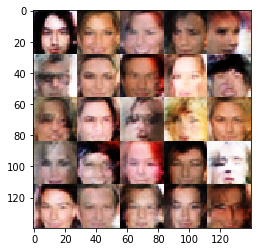

Epoch: 2/2... Step: 2340/3164... Discriminator Loss: 1.3971... Generator Loss: 0.7611
Epoch: 2/2... Step: 2360/3164... Discriminator Loss: 1.3675... Generator Loss: 0.7339
Epoch: 2/2... Step: 2380/3164... Discriminator Loss: 1.4548... Generator Loss: 0.8133
Epoch: 2/2... Step: 2400/3164... Discriminator Loss: 1.4226... Generator Loss: 0.8127


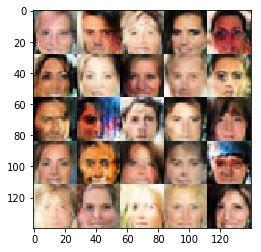

Epoch: 2/2... Step: 2420/3164... Discriminator Loss: 1.4289... Generator Loss: 0.5624
Epoch: 2/2... Step: 2440/3164... Discriminator Loss: 1.5095... Generator Loss: 0.5423
Epoch: 2/2... Step: 2460/3164... Discriminator Loss: 1.4309... Generator Loss: 0.6443
Epoch: 2/2... Step: 2480/3164... Discriminator Loss: 1.3984... Generator Loss: 0.6423


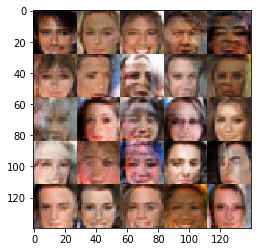

Epoch: 2/2... Step: 2500/3164... Discriminator Loss: 1.3842... Generator Loss: 0.6347
Epoch: 2/2... Step: 2520/3164... Discriminator Loss: 1.4301... Generator Loss: 0.6641
Epoch: 2/2... Step: 2540/3164... Discriminator Loss: 1.4003... Generator Loss: 0.6429
Epoch: 2/2... Step: 2560/3164... Discriminator Loss: 1.4521... Generator Loss: 0.7308


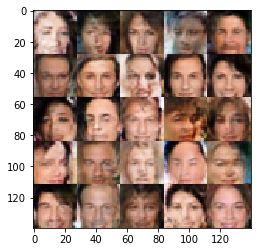

Epoch: 2/2... Step: 2580/3164... Discriminator Loss: 1.4228... Generator Loss: 0.7552
Epoch: 2/2... Step: 2600/3164... Discriminator Loss: 1.3843... Generator Loss: 0.7208
Epoch: 2/2... Step: 2620/3164... Discriminator Loss: 1.3915... Generator Loss: 0.6370
Epoch: 2/2... Step: 2640/3164... Discriminator Loss: 1.3479... Generator Loss: 0.6188


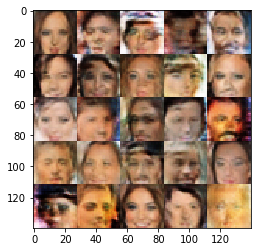

Epoch: 2/2... Step: 2660/3164... Discriminator Loss: 1.3879... Generator Loss: 0.6892
Epoch: 2/2... Step: 2680/3164... Discriminator Loss: 1.3762... Generator Loss: 0.7113
Epoch: 2/2... Step: 2700/3164... Discriminator Loss: 1.3548... Generator Loss: 0.9782
Epoch: 2/2... Step: 2720/3164... Discriminator Loss: 1.4054... Generator Loss: 0.6554


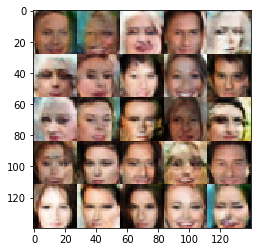

Epoch: 2/2... Step: 2740/3164... Discriminator Loss: 1.4003... Generator Loss: 0.8449
Epoch: 2/2... Step: 2760/3164... Discriminator Loss: 1.3008... Generator Loss: 0.7703
Epoch: 2/2... Step: 2780/3164... Discriminator Loss: 1.3556... Generator Loss: 0.7151
Epoch: 2/2... Step: 2800/3164... Discriminator Loss: 1.3703... Generator Loss: 0.6188


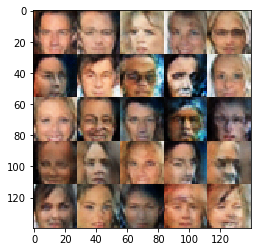

Epoch: 2/2... Step: 2820/3164... Discriminator Loss: 1.4111... Generator Loss: 0.6386
Epoch: 2/2... Step: 2840/3164... Discriminator Loss: 1.3763... Generator Loss: 0.6326
Epoch: 2/2... Step: 2860/3164... Discriminator Loss: 1.3960... Generator Loss: 0.6897
Epoch: 2/2... Step: 2880/3164... Discriminator Loss: 1.4072... Generator Loss: 0.6402


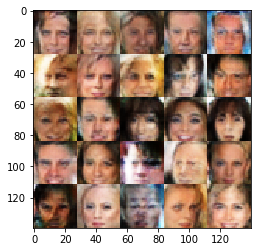

Epoch: 2/2... Step: 2900/3164... Discriminator Loss: 1.4358... Generator Loss: 0.7527
Epoch: 2/2... Step: 2920/3164... Discriminator Loss: 1.3862... Generator Loss: 0.6772
Epoch: 2/2... Step: 2940/3164... Discriminator Loss: 1.3933... Generator Loss: 0.7853
Epoch: 2/2... Step: 2960/3164... Discriminator Loss: 1.4253... Generator Loss: 0.5590


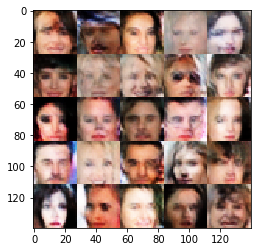

Epoch: 2/2... Step: 2980/3164... Discriminator Loss: 1.4252... Generator Loss: 0.8302
Epoch: 2/2... Step: 3000/3164... Discriminator Loss: 1.3522... Generator Loss: 0.8095
Epoch: 2/2... Step: 3020/3164... Discriminator Loss: 1.3599... Generator Loss: 0.7132
Epoch: 2/2... Step: 3040/3164... Discriminator Loss: 1.4203... Generator Loss: 0.6773


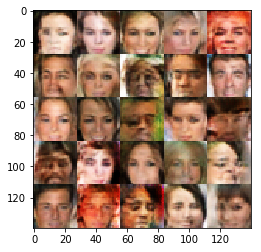

Epoch: 2/2... Step: 3060/3164... Discriminator Loss: 1.4249... Generator Loss: 0.7412
Epoch: 2/2... Step: 3080/3164... Discriminator Loss: 1.3854... Generator Loss: 0.7419
Epoch: 2/2... Step: 3100/3164... Discriminator Loss: 1.3587... Generator Loss: 0.7839
Epoch: 2/2... Step: 3120/3164... Discriminator Loss: 1.4354... Generator Loss: 0.5931


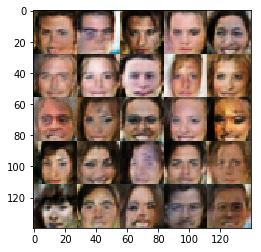

Epoch: 2/2... Step: 3140/3164... Discriminator Loss: 1.4340... Generator Loss: 0.8019
Epoch: 2/2... Step: 3160/3164... Discriminator Loss: 1.3796... Generator Loss: 0.7513


In [13]:
batch_size = 128
z_dim = 128
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.